In [5]:
# Ścieżka do pliku
seq_file_name = '600_56n17_1mm_-161_09_29_59_808'
# seq_file_name = '600_41n20_1_2mm_-161_08_03_50_784'
csv_path = f'../frames_output/{seq_file_name}/temperature_stats.csv'

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# --- KONFIGURACJA ---
IMAGE_DIR = f'../frames_output/{seq_file_name}/preview_fixed'
# IMAGE_DIR = f'frames_output/{seq_file_name}/no_ignition'
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- TRANSFORMACJE ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# --- DANE Z 2 ROIs ---
class ThermalDatasetMultiROI(Dataset):
    def __init__(self, image_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform
        self.roi_arc = (295, 410, 345, 480)   # ROI łuku
        self.roi_weld = (270, 250, 370, 400)  # ROI spoiny

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        arc_crop = img.crop(self.roi_arc)
        weld_crop = img.crop(self.roi_weld)
        if self.transform:
            arc_crop = self.transform(arc_crop)
            weld_crop = self.transform(weld_crop)
        return arc_crop, weld_crop, os.path.basename(self.files[idx])

# --- AUTOENCODER ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- PRZYGOTOWANIE ---
dataset = ThermalDatasetMultiROI(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model_arc = ConvAutoencoder().to(DEVICE)
model_weld = ConvAutoencoder().to(DEVICE)
optimizer_arc = optim.Adam(model_arc.parameters(), lr=0.001)
optimizer_weld = optim.Adam(model_weld.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- TRENING ---
for epoch in range(EPOCHS):
    model_arc.train()
    model_weld.train()
    loss_arc_sum, loss_weld_sum = 0.0, 0.0

    for arc, weld, _ in dataloader:
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        out_arc = model_arc(arc)
        loss_arc = criterion(out_arc, arc)
        optimizer_arc.zero_grad()
        loss_arc.backward()
        optimizer_arc.step()
        loss_arc_sum += loss_arc.item()

        out_weld = model_weld(weld)
        loss_weld = criterion(out_weld, weld)
        optimizer_weld.zero_grad()
        loss_weld.backward()
        optimizer_weld.step()
        loss_weld_sum += loss_weld.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Arc Loss: {loss_arc_sum:.4f} | Weld Loss: {loss_weld_sum:.4f}")

# --- DETEKCJA ANOMALII ---
model_arc.eval()
model_weld.eval()
errors_arc = []
errors_weld = []
filenames = []

with torch.no_grad():
    for arc, weld, fname in DataLoader(dataset, batch_size=1, shuffle=False):
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        recon_arc = model_arc(arc)
        recon_weld = model_weld(weld)

        err_arc = criterion(recon_arc, arc).item()
        err_weld = criterion(recon_weld, weld).item()

        errors_arc.append(err_arc)
        errors_weld.append(err_weld)
        filenames.append(fname[0])

# --- ANALIZA ---
thresh_arc = np.percentile(errors_arc, 95)
thresh_weld = np.percentile(errors_weld, 95)
anomalies_arc = [i for i, e in enumerate(errors_arc) if e > thresh_arc]
anomalies_weld = [i for i, e in enumerate(errors_weld) if e > thresh_weld]

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(errors_arc, label='Arc Error')
plt.axhline(y=thresh_arc, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
plt.title('Anomalie łuku')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(errors_weld, label='Weld Error')
plt.axhline(y=thresh_weld, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
plt.title('Anomalie spoiny')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:

torch.save(model_arc.state_dict(), "../models/autoencoder_arc_reference.pth")
torch.save(model_weld.state_dict(), "../models/autoencoder_weld_reference.pth")

# from MSE to SSIM 

Epoch 1/50 | Arc Loss: 5.1818 | Weld Loss: 5.3723
Epoch 2/50 | Arc Loss: 0.6646 | Weld Loss: 0.4603
Epoch 3/50 | Arc Loss: 0.3170 | Weld Loss: 0.1686
Epoch 4/50 | Arc Loss: 0.2370 | Weld Loss: 0.1251
Epoch 5/50 | Arc Loss: 0.1999 | Weld Loss: 0.1046
Epoch 6/50 | Arc Loss: 0.1758 | Weld Loss: 0.0918
Epoch 7/50 | Arc Loss: 0.1591 | Weld Loss: 0.0860
Epoch 8/50 | Arc Loss: 0.1451 | Weld Loss: 0.0780
Epoch 9/50 | Arc Loss: 0.1366 | Weld Loss: 0.0737
Epoch 10/50 | Arc Loss: 0.1292 | Weld Loss: 0.0707
Epoch 11/50 | Arc Loss: 0.1244 | Weld Loss: 0.0678
Epoch 12/50 | Arc Loss: 0.1204 | Weld Loss: 0.0654
Epoch 13/50 | Arc Loss: 0.1164 | Weld Loss: 0.0637
Epoch 14/50 | Arc Loss: 0.1134 | Weld Loss: 0.0618
Epoch 15/50 | Arc Loss: 0.1117 | Weld Loss: 0.0602
Epoch 16/50 | Arc Loss: 0.1087 | Weld Loss: 0.0590
Epoch 17/50 | Arc Loss: 0.1064 | Weld Loss: 0.0585
Epoch 18/50 | Arc Loss: 0.1052 | Weld Loss: 0.0556
Epoch 19/50 | Arc Loss: 0.1035 | Weld Loss: 0.0547
Epoch 20/50 | Arc Loss: 0.1016 | Weld Lo

/home/dburcon/.pyenv/versions/3.10.15/envs/thermal_3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


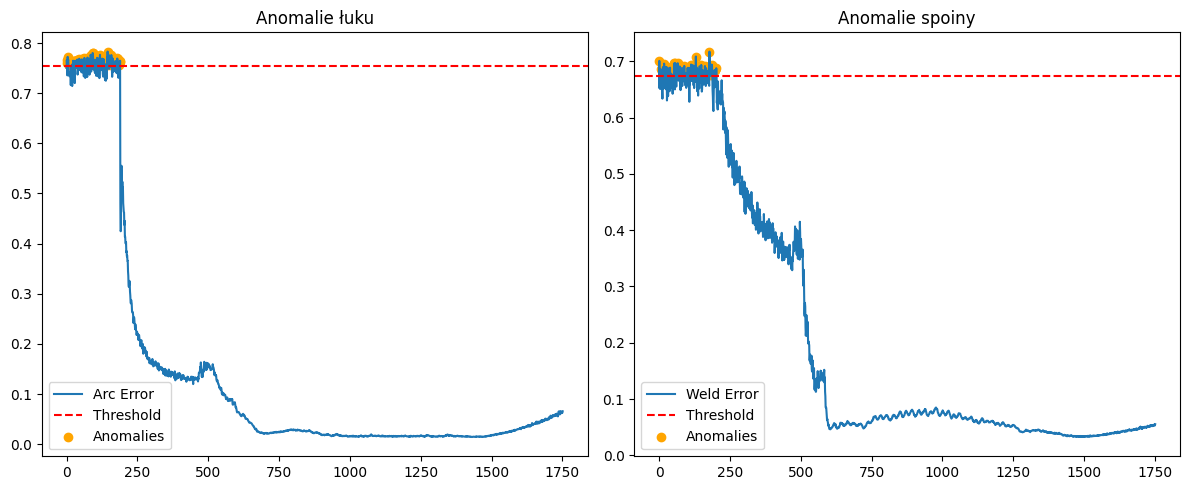

In [1]:
from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchvision.transforms.functional import to_pil_image

import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# --- KONFIGURACJA ---
seq_file_name = '600_56n17_1mm_-161_09_29_59_808'
IMAGE_DIR = f'../frames_output/{seq_file_name}/preview_fixed'
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- TRANSFORMACJE ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# --- DANE Z 2 ROIs ---
class ThermalDatasetMultiROI(Dataset):
    def __init__(self, image_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform
        self.roi_arc = (230, 420, 345, 480)    # (x1, y1, x2, y2)
        self.roi_weld = (230, 0, 345, 420)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        arc_crop = img.crop(self.roi_arc)
        weld_crop = img.crop(self.roi_weld)
        if self.transform:
            arc_crop = self.transform(arc_crop)
            weld_crop = self.transform(weld_crop)
        return arc_crop, weld_crop, os.path.basename(self.files[idx])

# --- AUTOENCODER ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- PRZYGOTOWANIE ---
dataset = ThermalDatasetMultiROI(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model_arc = ConvAutoencoder().to(DEVICE)
model_weld = ConvAutoencoder().to(DEVICE)
optimizer_arc = optim.Adam(model_arc.parameters(), lr=0.001)
optimizer_weld = optim.Adam(model_weld.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- TRENING ---
for epoch in range(EPOCHS):
    model_arc.train()
    model_weld.train()
    loss_arc_sum, loss_weld_sum = 0.0, 0.0

    for arc, weld, _ in dataloader:
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        out_arc = model_arc(arc)
        loss_arc = criterion(out_arc, arc)
        optimizer_arc.zero_grad()
        loss_arc.backward()
        optimizer_arc.step()
        loss_arc_sum += loss_arc.item()

        out_weld = model_weld(weld)
        loss_weld = criterion(out_weld, weld)
        optimizer_weld.zero_grad()
        loss_weld.backward()
        optimizer_weld.step()
        loss_weld_sum += loss_weld.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Arc Loss: {loss_arc_sum:.4f} | Weld Loss: {loss_weld_sum:.4f}")

# --- DETEKCJA ANOMALII + ZAPIS ---
model_arc.eval()
model_weld.eval()
errors_arc = []
errors_weld = []
filenames = []

anomalia_path = './anomalie_output'
os.makedirs(anomalia_path, exist_ok=True)

with torch.no_grad():
    for arc, weld, fname in DataLoader(dataset, batch_size=1, shuffle=False):
        arc = arc.to(DEVICE)
        weld = weld.to(DEVICE)

        recon_arc = model_arc(arc)
        recon_weld = model_weld(weld)

        err_arc = (1.0 - ssim(recon_arc, arc)).cpu().item()
        err_weld = (1.0 - ssim(recon_weld, weld)).cpu().item()

        errors_arc.append(err_arc)
        errors_weld.append(err_weld)
        filenames.append(fname[0])

# --- ANALIZA ---
thresh_arc = np.percentile(errors_arc, 95)
thresh_weld = np.percentile(errors_weld, 95)
anomalies_arc = [i for i, e in enumerate(errors_arc) if e > thresh_arc]
anomalies_weld = [i for i, e in enumerate(errors_weld) if e > thresh_weld]

# --- ZAPIS ANOMALII + HEATMAPY ---
for i in anomalies_arc:
    fname = filenames[i]
    arc, _, _ = dataset[i]
    recon = model_arc(arc.unsqueeze(0).to(DEVICE)).cpu().squeeze(0)

    diff = torch.abs(recon - arc).squeeze().detach().numpy()

    plt.imshow(diff, cmap='hot')
    plt.title(f"Arc anomaly: {fname}")
    plt.colorbar()
    plt.savefig(os.path.join(anomalia_path, f"heatmap_arc_{fname}.png"))
    plt.close()

    img = Image.open(os.path.join(IMAGE_DIR, fname))
    img.save(os.path.join(anomalia_path, f"anomaly_arc_{fname}"))

for i in anomalies_weld:
    fname = filenames[i]
    _, weld, _ = dataset[i]
    recon = model_weld(weld.unsqueeze(0).to(DEVICE)).cpu().squeeze(0)

    diff = torch.abs(recon - arc).squeeze().detach().numpy()

    plt.imshow(diff, cmap='hot')
    plt.title(f"Weld anomaly: {fname}")
    plt.colorbar()
    plt.savefig(os.path.join(anomalia_path, f"heatmap_weld_{fname}.png"))
    plt.close()

    img = Image.open(os.path.join(IMAGE_DIR, fname))
    img.save(os.path.join(anomalia_path, f"anomaly_weld_{fname}"))

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(errors_arc, label='Arc Error')
plt.axhline(y=thresh_arc, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
plt.title('Anomalie łuku')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(errors_weld, label='Weld Error')
plt.axhline(y=thresh_weld, color='red', linestyle='--', label='Threshold')
plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
plt.title('Anomalie spoiny')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:

torch.save(model_arc.state_dict(), "../models/ssim/autoencoder_arc_reference.pth")
torch.save(model_weld.state_dict(), "../models/ssim/autoencoder_weld_reference.pth")